In [64]:
import pandas as pd
import numpy as np

servers = pd.read_excel('statistics_for_all_servers.xlsx', sheet_name='week_stats')
servers

,vm,date,metric,max_value,min_value,avg_value
0,metrics_DataLake-DBN1,2025-11-25,cpu.usage.average,5.110000e+00,4.480000e+00,4.681429e+00
1,metrics_DataLake-DBN1,2025-11-26,cpu.usage.average,4.910000e+00,4.240000e+00,4.629792e+00
2,metrics_DataLake-DBN1,2025-11-27,cpu.usage.average,5.080000e+00,4.420000e+00,4.755208e+00
3,metrics_DataLake-DBN1,2025-11-28,cpu.usage.average,5.230000e+00,4.710000e+00,4.905417e+00
4,metrics_DataLake-DBN1,2025-11-29,cpu.usage.average,5.320000e+00,4.840000e+00,5.033542e+00
5,metrics_DataLake-DBN1,2025-11-30,cpu.usage.average,5.410000e+00,4.860000e+00,5.127500e+00
6,metrics_DataLake-DBN1,2025-12-01,cpu.usage.average,1.134000e+01,4.930000e+00,5.337917e+00
7,metrics_DataLake-DBN1,2025-11-25,cpu.usagemhz.average,2.450000e+03,2.151000e+03,2.245357e+03
8,metrics_DataLake-DBN1,2025-11-26,cpu.usagemhz.average,2.356000e+03,2.032000e+03,2.220479e+03
9,metrics_DataLake-DBN1,2025-11-27,cpu.usagemhz.average,2.434000e+03,2.118000e+03,2.280104e+03


In [65]:
all_vms = servers['vm'].unique()
all_metrics = servers['metric'].unique()
all_dates =servers['date'].unique()

In [66]:
len(all_vms)

20

Попробуем определить серверы с низкой нагрузкой.

In [67]:
all_metrics

array(['cpu.usage.average', 'cpu.usagemhz.average', 'cpu.ready.summation',
       'mem.consumed.average', 'mem.overhead.average',
       'mem.swapinrate.average', 'mem.swapoutrate.average',
       'mem.usage.average', 'mem.vmmemctl.average',
       'disk.maxtotallatency.latest', 'disk.provisioned.latest',
       'disk.unshared.latest', 'disk.usage.average', 'disk.used.latest',
       'net.usage.average', 'sys.uptime.latest'], dtype=object)

Рассчитаем композитарные признаки недогруженности серверов, можно вычислить следующие показатели:

1. Универсальный Score недогруженности:

    ```
       underutilization_score = (
            (cpu.usage.average / 100) * 0.4 +
            (mem.usage.average / 100) * 0.3 +
            (disk.usage.average / 100) * 0.2 +
            (net.usage.average / 100) * 0.1
       )
    ```


In [68]:
def calculate_metric_avg(vm: str, date: str, metric: str):
    data = servers[servers['vm']==vm]
    data = data[data['date']==date]
    values = data[data['metric']==metric]
    return list(values['avg_value'])[0]

In [72]:
def is_weak_load(vm, date,
                     cpu_down, cpu_up,
                     mem_down, mem_up,
                     disk_down, disk_up,
                     net_down, net_up,
                     label):
    cpu = calculate_metric_avg(vm, date, 'cpu.usage.average')
    mem = calculate_metric_avg(vm, date, 'mem.usage.average')
    disk = calculate_metric_avg(vm, date, 'disk.usage.average')
    net = calculate_metric_avg(vm, date, 'net.usage.average')
    if (
        cpu_down <= cpu and cpu < cpu_up
        and
        mem_down <= mem and mem < mem_up
        and
        disk_down <= disk and disk < disk_up
        and
        net_down <= net and net < net_up
    ):
        is_load = 1
    else:
        is_load = 0
    return (is_load, label)

простои:
0 <= cpu < 10 & 0 <= mem < 25 & 0 <= disk < 1024 & 0 <= net < 1024
очень низкая нагрузка:
0 <= cpu < 10 & 0 <= mem < 25 & 0 <= disk <  & 0 <= net < 1024

нормальная нагрузка:
cpu

высокая нагрузка:
80 <= cpu < 100 & 0 <= mem < 100 & 0 <= disk <= 

In [ ]:
is_weak_load(vm, date, 0, 10, 0, 25, 0, 1024, 0, 1024, 'простои')


In [69]:
def is_very_weak_load(vm, date):
    cpu = calculate_metric_avg(vm, date, 'cpu.usage.average')
    mem = calculate_metric_avg(vm, date, 'mem.usage.average')
    disk = calculate_metric_avg(vm, date, 'disk.usage.average')
    net = calculate_metric_avg(vm, date, 'net.usage.average')
    if (
        cpu < 10 and
        mem < 25 and
        disk < 1024 and
        net < 1024
    ):
        is_load = 1
    else:
        is_load = 0
    return is_load

In [70]:
def is_weak_load(vm, date):
    cpu = calculate_metric_avg(vm, date, 'cpu.usage.average')
    mem = calculate_metric_avg(vm, date, 'mem.usage.average')
    disk = calculate_metric_avg(vm, date, 'disk.usage.average')
    net = calculate_metric_avg(vm, date, 'net.usage.average')
    if (
        cpu < 15 and
        mem < 25 and
        disk < 2048 and
        net < 2048
    ):
        is_load = 1
    else:
        is_load = 0
    return is_load

In [31]:
from tqdm import tqdm

pd.set_option('display.max_rows', None)

result = pd.DataFrame(columns=['vm', 'date', 'is_weak_load', 'is_very_weak_load'])

for vm in all_vms:
    for date in all_dates:
        score1 = is_weak_load(vm, date)
        score2 = is_very_weak_load(vm, date)
        row = [vm, date, score1, score2]
        result.loc[len(result)] = row

result

,vm,date,is_weak_load,is_very_weak_load
0,metrics_DataLake-DBN1,2025-11-25,1,1
1,metrics_DataLake-DBN1,2025-11-26,1,1
2,metrics_DataLake-DBN1,2025-11-27,1,1
3,metrics_DataLake-DBN1,2025-11-28,1,1
4,metrics_DataLake-DBN1,2025-11-29,1,1
5,metrics_DataLake-DBN1,2025-11-30,1,1
6,metrics_DataLake-DBN1,2025-12-01,1,1
7,metrics_DataLake-DBN2,2025-11-25,1,1
8,metrics_DataLake-DBN2,2025-11-26,1,1
9,metrics_DataLake-DBN2,2025-11-27,1,1


In [49]:
result.to_excel('is_weak_load.xlsx')

In [32]:
is_weak_load_arr = result['is_weak_load']
is_very_weak_load_arr = result['is_very_weak_load']
n = len(result)
level = []

for i in range(n):
    if is_weak_load_arr[i] and is_very_weak_load_arr[i]:
        level.append('очень низкая')
    elif not is_very_weak_load_arr[i] and is_weak_load_arr[i]:
        level.append('низкая')
    else:
        level.append('нормальная')
                     
result['Уровень нагрузки'] = level

In [33]:
result

,vm,date,is_weak_load,is_very_weak_load,Уровень нагрузки
0,metrics_DataLake-DBN1,2025-11-25,1,1,очень низкая
1,metrics_DataLake-DBN1,2025-11-26,1,1,очень низкая
2,metrics_DataLake-DBN1,2025-11-27,1,1,очень низкая
3,metrics_DataLake-DBN1,2025-11-28,1,1,очень низкая
4,metrics_DataLake-DBN1,2025-11-29,1,1,очень низкая
5,metrics_DataLake-DBN1,2025-11-30,1,1,очень низкая
6,metrics_DataLake-DBN1,2025-12-01,1,1,очень низкая
7,metrics_DataLake-DBN2,2025-11-25,1,1,очень низкая
8,metrics_DataLake-DBN2,2025-11-26,1,1,очень низкая
9,metrics_DataLake-DBN2,2025-11-27,1,1,очень низкая


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

1


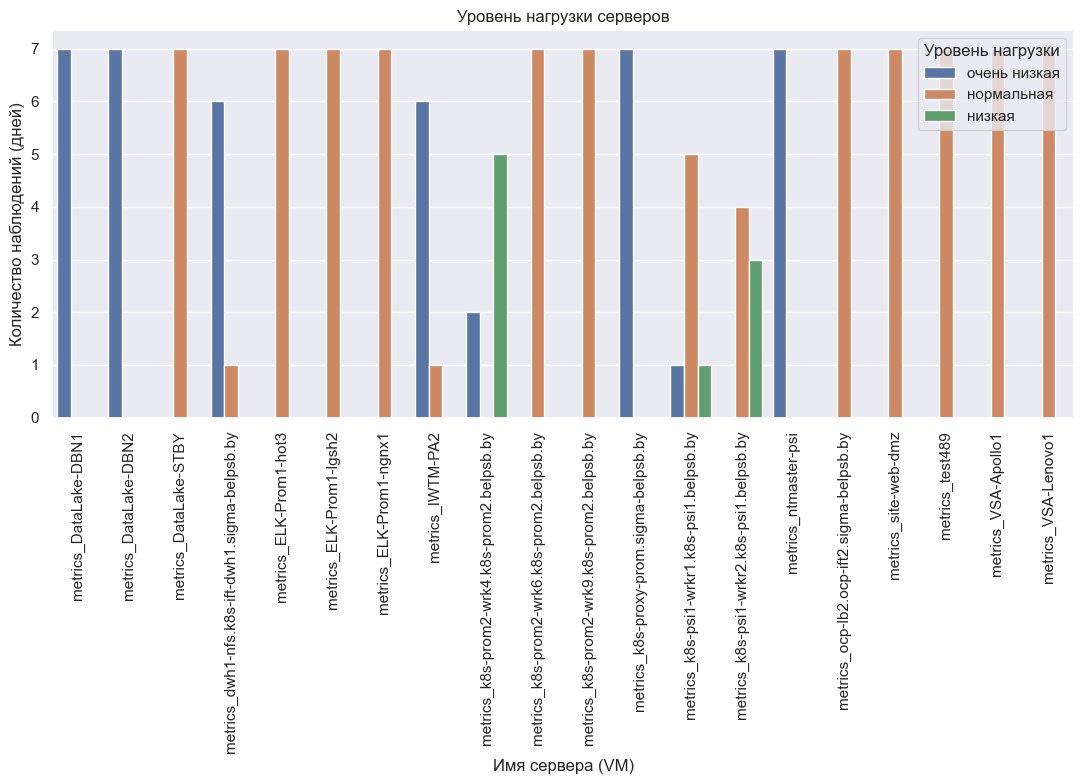

In [34]:
# Установка темы seaborn для более приятного вида графиков
print(1)
sns.set_theme()

# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(11, 8))

# Построение графика распределения нагрузки на серверах с помощью seaborn
sns.countplot(x='vm', hue='Уровень нагрузки', data=result, ax=ax)

# Настройка заголовков и меток для лучшей читаемости
ax.set_title('Уровень нагрузки серверов')
ax.set_xlabel('Имя сервера (VM)')
ax.set_ylabel('Количество наблюдений (дней)')

# Поворот меток на оси X для лучшей читаемости
plt.xticks(rotation=90)

# Отображение графика
plt.tight_layout()
plt.show()

In [35]:
result

,vm,date,is_weak_load,is_very_weak_load,Уровень нагрузки
0,metrics_DataLake-DBN1,2025-11-25,1,1,очень низкая
1,metrics_DataLake-DBN1,2025-11-26,1,1,очень низкая
2,metrics_DataLake-DBN1,2025-11-27,1,1,очень низкая
3,metrics_DataLake-DBN1,2025-11-28,1,1,очень низкая
4,metrics_DataLake-DBN1,2025-11-29,1,1,очень низкая
5,metrics_DataLake-DBN1,2025-11-30,1,1,очень низкая
6,metrics_DataLake-DBN1,2025-12-01,1,1,очень низкая
7,metrics_DataLake-DBN2,2025-11-25,1,1,очень низкая
8,metrics_DataLake-DBN2,2025-11-26,1,1,очень низкая
9,metrics_DataLake-DBN2,2025-11-27,1,1,очень низкая


In [39]:
len(all_servers)

NameError: name 'all_servers' is not defined

1


C:\Users\golubitskaya_a\AppData\Local\Temp\ipykernel_40932\374147306.py:56: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



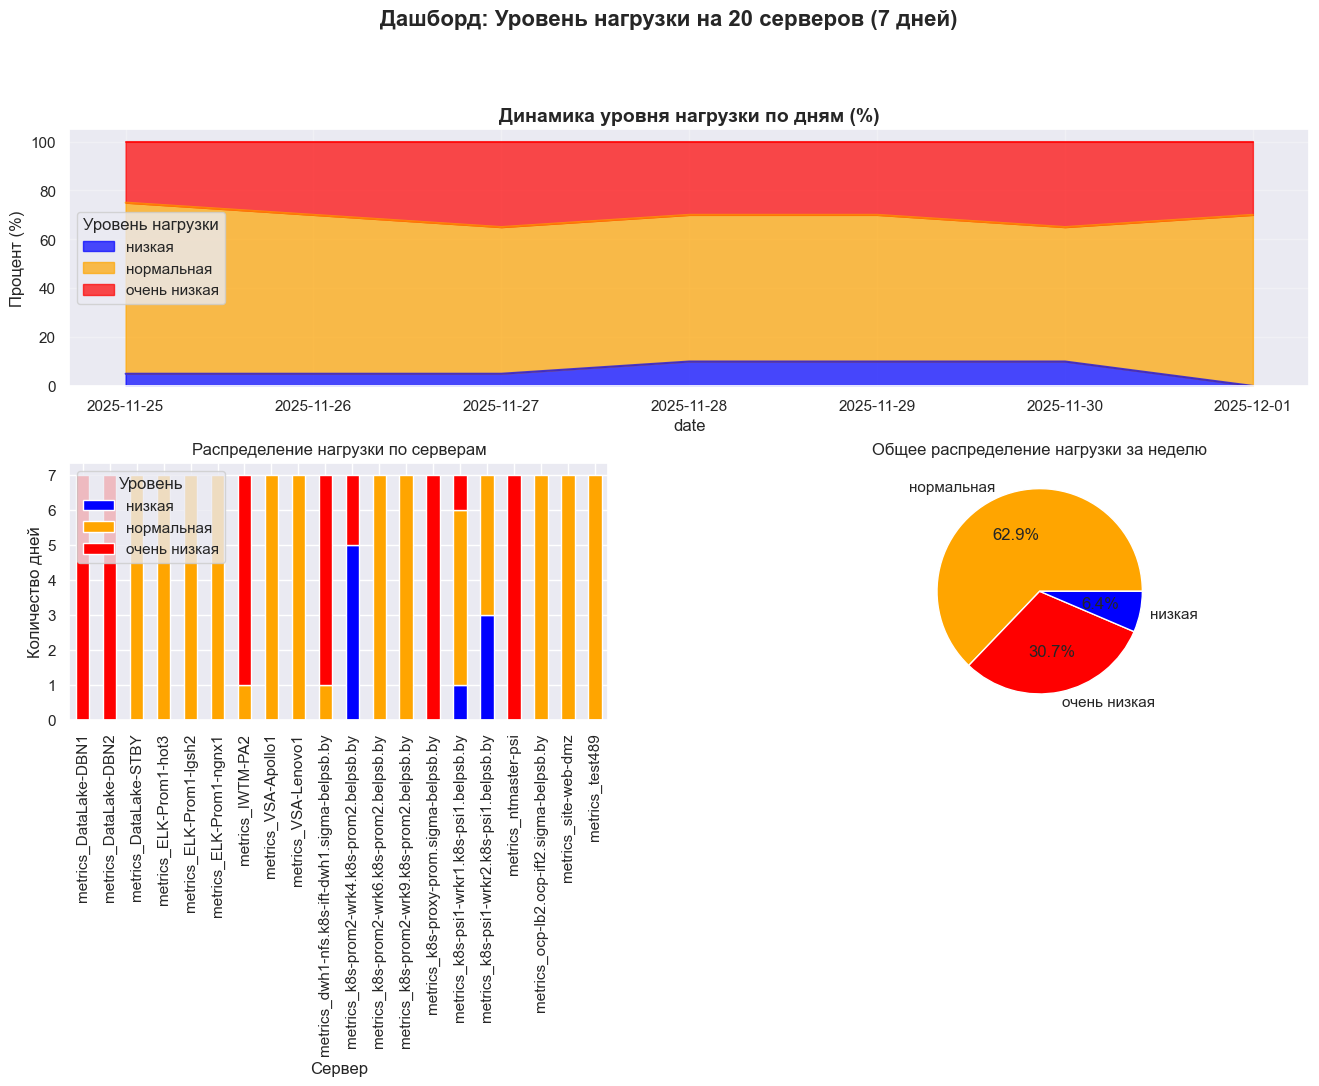

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

print(1)

# 1. Генерация данных
np.random.seed(42)
servers = result['vm']
days = pd.date_range(start='2025-11-25', periods=7, freq='D')

# 2. Агрегация
pivot = result.pivot_table(index='date', columns='Уровень нагрузки', aggfunc='size', fill_value=0)
percent_df = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 3. Построение дашборда
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

# 3.1. Областной график (проценты)
ax1 = fig.add_subplot(gs[0, :])
percent_df.plot(kind='area', stacked=True, ax=ax1, color=['blue', 'orange', 'red'], alpha=0.7)
ax1.set_title('Динамика уровня нагрузки по дням (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Процент (%)')
ax1.legend(title='Уровень нагрузки')
ax1.grid(True, alpha=0.3)

# 3.2. Гистограмма по серверам
ax2 = fig.add_subplot(gs[1, 0])
server_load = result.groupby(['vm', 'Уровень нагрузки']).size().unstack(fill_value=0)
server_load.plot(kind='bar', stacked=True, ax=ax2, color=['blue', 'orange', 'red'])
ax2.set_title('Распределение нагрузки по серверам', fontsize=12)
ax2.set_xlabel('Сервер')
ax2.set_ylabel('Количество дней')
ax2.tick_params(axis='x', rotation=90)
ax2.legend(title='Уровень')

# 3.3. Круговая диаграмма за всё время
ax3 = fig.add_subplot(gs[1, 1])
total = result['Уровень нагрузки'].value_counts()
ax3.pie(total.values, labels=total.index, autopct='%1.1f%%', colors=['orange', 'red', 'blue'])
ax3.set_title('Общее распределение нагрузки за неделю', fontsize=12)

# 3.4. Тепловая карта
# ax4 = fig.add_subplot(gs[2, :])
# heatmap_data = result.pivot_table(index='date', columns='vm', values='Уровень нагрузки', 
#                               aggfunc=lambda x: 0 if 'очень низкая' in x.values else 1 if 'низкая' in x.values else 2)
# sns.heatmap(heatmap_data.T, cmap='RdYlGn_r', ax=ax4, cbar_kws={'label': '0=очень низкая, 1=низкая, 2=нормальная'})
# ax4.set_title('Тепловая карта нагрузки по серверам и дням', fontsize=14, fontweight='bold')
# ax4.set_xlabel('Дата')
# ax4.set_ylabel('Сервер')

plt.suptitle('Дашборд: Уровень нагрузки на 20 серверов (7 дней)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [49]:
!pip install dash

   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/7.9 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/7.9 MB 3.2 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/7.9 MB 3.5 MB/s eta 0:00:02
   ----------------- ---------------------- 3.4/7.9 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.9 MB 4.0 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/7.9 MB 4.3 MB/s eta 0:00:01
   --------------------------------- ------ 6.6/7.9 MB 4.5 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/7.9 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 4.2 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [dash]
   -------------------- ------------------- 1/2 [dash]
   ---------------------------------------- 2/2 [dash]



In [52]:
!pip install dash-bootstrap-components

In [58]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc

# 1. Генерация примерных данных (замените на свои)
np.random.seed(42)
servers = result['vm']
days = pd.date_range(start='2025-11-25', periods=7, freq='D')

# 2. Агрегация данных в проценты по дням
pivot = result.pivot_table(index='date', columns='Уровень нагрузки', aggfunc='size', fill_value=0)
percent_df = pivot.div(pivot.sum(axis=1), axis=0) * 100
percent_df = percent_df.reset_index().melt(id_vars='date', value_name='Процент', var_name='Уровень нагрузки')

# 3. Создание Dash-приложения
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("📈 Дашборд нагрузки серверов (20 серверов)", className="text-center my-4"), width=12)
    ]),
    dbc.Row([
        dbc.Col([
            html.Label("Выберите уровень нагрузки:"),
            dcc.Dropdown(
                id='load-level-dropdown',
                options=[{'label': lev, 'value': lev} for lev in ['очень низкая', 'низкая', 'нормальная']],
                value=['Очень низкая', 'Низкая', 'Нормальная'],
                multi=True
            )
        ], width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='stacked-area'), width=12),
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='heatmap'), width=12),
    ])
], fluid=True)

@app.callback(
    Output('stacked-area', 'figure'),
    Input('load-level-dropdown', 'value')
)
def update_stacked_area(selected_levels):
    filtered = percent_df[percent_df['Уровень нагрузки'].isin(selected_levels)]
    fig = px.area(filtered, x='date', y='Процент', color='Уровень нагрузки',
                  title="Динамика уровня нагрузки по дням (%)",
                  color_discrete_map={'очень низкая': 'green', 'низкая': 'orange', 'нормальная': 'red'})
    fig.update_layout(yaxis_title="Процент (%)", xaxis_title="Дата")
    return fig

@app.callback(
    Output('heatmap', 'figure'),
    Input('load-level-dropdown', 'value')
)
def update_heatmap(selected_levels):
    # Создаем сводную таблицу для тепловой карты
    heatmap_data = result[result['Уровень нагрузки'].isin(selected_levels)]
    heatmap_pivot = heatmap_data.pivot_table(index='date', columns='vm', 
                                             values='Уровень нагрузки', aggfunc=lambda x: 1 if 'Высокая' in x.values else 0)
    fig = px.imshow(heatmap_pivot.T, 
                    title="Тепловая карта высоких нагрузок по серверам (1 = высокая)",
                    labels=dict(x="Дата", y="Сервер", color="Нагрузка"))
    fig.update_layout(height=500)
    return fig

In [60]:
app.run(host='127.0.0.1', port=8050, debug=True)